In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import random
from sklearn.preprocessing import OneHotEncoder
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

training_rate = 0.001


inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
L1 = tf.nn.conv2d(inputs_, W1, strides=[1,1,1,1], padding='SAME')
L1 = tf.nn.leaky_relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
# 현재 크기 : 14x14x32

W2 = tf.Variable(tf.random_normal([3,3,32,64], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding='SAME')
L2 = tf.nn.leaky_relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
# 현재 크기 : 7x7x64

W3 = tf.Variable(tf.random_normal([3,3,64,128], stddev=0.01))
L3 = tf.nn.conv2d(L2, W3, strides=[1,1,1,1], padding='SAME')
L3 = tf.nn.leaky_relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
# 현재 크기 : 4*4*16

## 디코더
noise_sample1 = tf.image.resize_nearest_neighbor(L3, (7,7))
W4 = tf.Variable(tf.random_normal([3,3,128,32], stddev=0.01))
L4 = tf.nn.conv2d(noise_sample1, W4, strides=[1,1,1,1], padding='SAME')
L4 = tf.nn.leaky_relu(L4)
# 현재 크기 : 7x7x16

noise_sample2 = tf.image.resize_nearest_neighbor(L4, (14,14))
W5 = tf.Variable(tf.random_normal([3,3,32,32], stddev=0.01))
L5 = tf.nn.conv2d(noise_sample2, W5, strides=[1,1,1,1], padding='SAME')
L5 = tf.nn.leaky_relu(L5)
# 현재 크기 :14x14x32

noise_sample3 = tf.image.resize_nearest_neighbor(L5, (28,28))
W6 = tf.Variable(tf.random_normal([3,3,32,16], stddev=0.01))
L6 = tf.nn.conv2d(noise_sample3, W6, strides=[1,1,1,1], padding='SAME')
L6 = tf.nn.leaky_relu(L6)
# 현재 크기 : 28x28x32

W7 = tf.Variable(tf.random_normal([3,3,16,1], stddev=0.01))
L7 = tf.nn.conv2d(L6, W7, strides=[1,1,1,1], padding='SAME')

logits = tf.layers.conv2d(L7, 1, (3,3), padding='same', activation=None)
# resize를 시켜서 28*28*32로 키운 데이터를 다시 28*28*1로 줄인다.
# 학습되어 출력되는 데이터로 이를 원본 이미지와 비교해서 노이즈를 제거하는 학습을 시킴

decoded = tf.nn.sigmoid(L7, name='decoded')
# 학습된 신경망으로 이 신경망을 가지고 노이즈 이미지들의 노이즈를 제거하는데 이용합니다.

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(training_rate).minimize(cost)


sess = tf.Session()
training_period = 20
batch_size = 100
noise_factor = 1
# 노이즈의 크기를 조절하는 인수(클수록 노이즈 증가)

sess.run(tf.global_variables_initializer())
for period in range(training_period):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # 원본이미지에 노이즈를 더해 input_data를 만듭니다.
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # np.clip을 사용하여 노이즈 이미지의 최솟값을 0 최대값을 1로 정합니다
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # 노이즈 이미지를 input_data로 원본 imgs를 target으로 하여 학습을 진행합니다.
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

    if period % 1 == 0 or period == training_period-1:
        print('Period:', '%04d' % (period + 1), 'cost =', '{:.9f}'.format(batch_cost))

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Period: 0001 cost = 0.205286950
Period: 0002 cost = 0.180737510
Period: 0003 cost = 0.171095744
Period: 0004 cost = 0.162108675
Period: 0005 cost = 0.162529215
Period: 0006 cost = 0.161586463
Period: 0007 cost = 0.151293129
Period: 0008 cost = 0.156956047
Period: 0009 cost = 0.151729748
Period: 0010 cost = 0.150526851
Period: 0011 cost = 0.153786629
Period: 0012 cost = 0.149555802
Period: 0013 cost = 0.155751333
Period: 0014 cost = 0.150056928
Period: 0015 cost = 0.147047088
Period: 0016 cost = 0.149866223
Period: 0017 cost = 0.154047742
Period: 0018 cost = 0.144537687
Period: 0019 cost = 0.147681639
Period: 0020 cost = 0.142355651


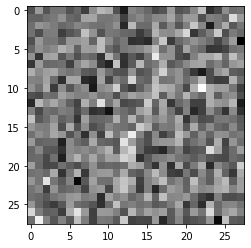

In [9]:
# 이러한 방법을 사용하여 노이즈를 생성해보았습니다.

# 실제 위의 훈련에서도 사람의 눈으로는 거의 판별이 불가능한 정도의 수준까지 노이즈를 넣어보았습니다.

temp_img = mnist.test.images[2]
temp_noisy_img = temp_img + 1 * np.random.randn(*temp_img.shape)

plt.imshow(temp_noisy_img.reshape(28,28), cmap='gray')

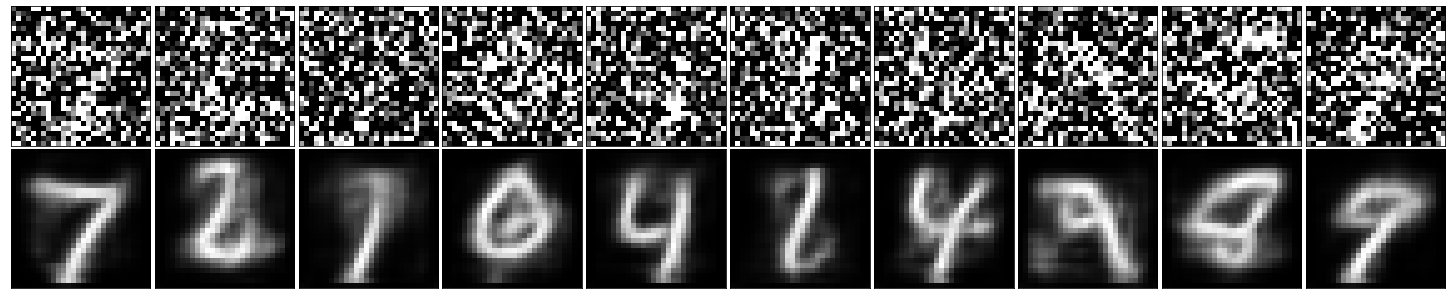

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:5000]

# 랜덤하게 노이즈를 만듭니다.(noise_factor = 1)
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reshape_img = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((-1, 28, 28, 1))})

# 노이즈이미지와 docoded신경망을 사용하여 

# 노이즈를 제거한 이미지를 비교해보면 아래와 같이 나옵니다.

for images, row in zip([noisy_imgs,reshape_img], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad = 0.1)

In [11]:
reshape_img = np.reshape(reshape_img,[-1,784])
x_data = reshape_img

#decode를 통해서 노이즈를 제거한 이미즈를 x_data로 사용하여 
#원래의 값과 one_hot방식으로 비교하여 학습을 시켰습니다.

y_data = mnist.test.labels[:5000]

# reshape_img가 위 단계에서 mnist.test.images를 가지고 했기 때문에 목표치를 해당 이미지의 labels로 했습니다.

y_data = np.reshape(y_data,[-1,1])

enc = OneHotEncoder()
enc.fit(y_data)
y_data = enc.transform(y_data).toarray()

# 기본적으로 [7,3,4,5,………..] 이런식으로 되어있는 데이터들을 onthotencoder를 사용하여 학습에 알맞게 변환했습니다.

train_input = x_data
train_label = y_data

C:\Users\Seo\.conda\envs\cuda\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [12]:
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

tf.reset_default_graph()

learning_rate = 0.001
training_period = 50
batch_size = 200

rate = tf.placeholder(tf.float32)

# 아래는 신경망으로 4개의 레이어를 사용하여 학습을 진행했고 신경망의 종류는 leaky_relu를 사용했습니다.
# dropout방식은 학습 중 랜덤하게 신경망을 꺼서 특정 부분의 학습을 극대화 시키는 방법으로 더 효율적인 학습을 위해 사용하였습니다.

X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])

W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.leaky_relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L1 = tf.nn.dropout(L1, rate=rate)

W2 = tf.Variable(tf.random_normal([3, 3, 32, 128], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.leaky_relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, rate=rate)

W3 = tf.Variable(tf.random_normal([3, 3, 128, 64], stddev=0.01))
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.leaky_relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, rate=rate)
L3_flat = tf.reshape(L3, [-1, 64 * 4 * 4])

W4 = tf.get_variable("W4", shape=[64 * 4 * 4, 256],initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([256]))
L4 = tf.nn.leaky_relu(tf.matmul(L3_flat, W4) + b4)
L4 = tf.nn.dropout(L4, rate=rate)

W5 = tf.get_variable("W5", shape=[256, 10], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L4, W5) + b5

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for period in range(training_period):
    avg_cost = 0
    total_batch = int(5000 / batch_size)

    for i in range(total_batch):
        start = ((i+1) * batch_size) - batch_size
        end = ((i+1) * batch_size)
        batch_xs = train_input[start:end]
        batch_ys = train_label[start:end]
        feed_dict = {X: batch_xs, Y: batch_ys, rate : 0.3}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
    if period % 10 == 0 or period == training_period-1:
        print('Period:', '%04d' % (period + 1), 'cost =', '{:.9f}'.format(avg_cost))

# logits이 학습된 신경망이므로 이 신경망을 사용하여 argmax(가장 큰 수를 출력시킴)를 사용하여 target과 비교를 해보았습니다.

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 위의 학습에서는 mnist.test.image를 5000번째까지를 사용해 학습을 했고 정확도 테스트는 아래와 같이 다른 이미지(5001~)를 사용했습니다.

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images[5000:], Y: mnist.test.labels[5000:], rate: 0}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Period: 0001 cost = 2.640931444
Period: 0011 cost = 0.749041965
Period: 0021 cost = 0.639034071
Period: 0031 cost = 0.583431177
Period: 0041 cost = 0.507607107
Period: 0050 cost = 0.457435243
Accuracy: 0.9368
